In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import lightgbm as lgb
from sklearn.model_selection import GroupKFold

# local modules
import sys
sys.path.append("../../src")
from preproc import preprocess_data

***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../../data/raw")
path_processed = Path("../../data/processed")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Call the function
df_train, df_test, numerical_cols, categorical_cols = preprocess_data(
    df_train,
    df_test,
    scale_utility=True
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


In [4]:
embeddings = pd.read_parquet(path_processed / "embeddings.parquet")
embeddings.drop(columns=["rewritten_rules"], inplace=True)
embeddings.head()

,Id,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511,embedding_512
0,0,-0.006283,-0.065378,-0.015272,-0.052669,-0.062972,0.024595,0.01896,0.044483,-0.009421,...,0.049191,0.006626,-0.007878,0.005538,0.035853,0.076153,-0.020306,0.028923,0.003965,0.044013
1,1,-0.006283,-0.065378,-0.015272,-0.052669,-0.062972,0.024595,0.01896,0.044483,-0.009421,...,0.049191,0.006626,-0.007878,0.005538,0.035853,0.076153,-0.020306,0.028923,0.003965,0.044013
2,2,-0.006283,-0.065378,-0.015272,-0.052669,-0.062972,0.024595,0.01896,0.044483,-0.009421,...,0.049191,0.006626,-0.007878,0.005538,0.035853,0.076153,-0.020306,0.028923,0.003965,0.044013
3,3,-0.006283,-0.065378,-0.015272,-0.052669,-0.062972,0.024595,0.01896,0.044483,-0.009421,...,0.049191,0.006626,-0.007878,0.005538,0.035853,0.076153,-0.020306,0.028923,0.003965,0.044013
4,4,-0.006283,-0.065378,-0.015272,-0.052669,-0.062972,0.024595,0.01896,0.044483,-0.009421,...,0.049191,0.006626,-0.007878,0.005538,0.035853,0.076153,-0.020306,0.028923,0.003965,0.044013


In [5]:
df_train = pd.merge(df_train, embeddings, on=["Id"], how="left", indicator=True)
df_train["_merge"].value_counts()

_merge
both          233234
left_only          0
right_only         0
Name: count, dtype: int64

In [6]:
numerical_cols.extend(embeddings.columns[1:])
print(len(numerical_cols))

1100


In [7]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns in the training data
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])

# Transform the numerical columns in the test data
# df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])

print(f"Applied StandardScaler to {len(numerical_cols)} numerical columns.")

Applied StandardScaler to 1100 numerical columns.


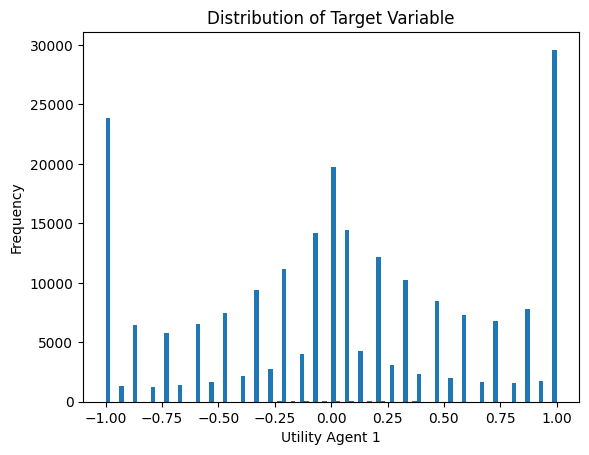

In [8]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()


***
### train model


In [9]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

target = 'utility_agent1'
#target = 'utility_agent1_scaled'

# Define the parameters
params = {
    'objective': "regression" if target == 'utility_agent1' else "cross_entropy",
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1,  # Set lower verbosity
    'linear_tree': True,  # Enable linear tree
    'linear_lambda': 1e-1,
}

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
    y_train, y_val = X_train[target], X_val[target]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(
        data=X_train[numerical_cols + categorical_cols],
        label=y_train,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )
    val_data = lgb.Dataset(
        data=X_val[numerical_cols + categorical_cols],
        label=y_val,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[lgb.log_evaluation(period=25)]
    )
    
    # Save the trained model to the list
    trained_models.append(model)

    # predict on validation set
    y_pred = model.predict(X_val[numerical_cols + categorical_cols])

    
    if target == "utility_agent1_scaled":
        # scale back predictions and true values to -1 to 1 range
        y_pred = y_pred * 2 - 1
        y_val = y_val * 2 - 1
    else:
        y_pred = np.clip(y_pred, -1, 1)
    
    # Compute RMSE on scaled values
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_val
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))


Fold 1
[25]	valid_0's rmse: 0.529908
[50]	valid_0's rmse: 0.506773
[75]	valid_0's rmse: 0.495644
[100]	valid_0's rmse: 0.493506
[125]	valid_0's rmse: 0.490553
[150]	valid_0's rmse: 0.489479
[175]	valid_0's rmse: 0.487964
[200]	valid_0's rmse: 0.487193
[225]	valid_0's rmse: 0.487238
[250]	valid_0's rmse: 0.48647
[275]	valid_0's rmse: 0.486438
[300]	valid_0's rmse: 0.48571
[325]	valid_0's rmse: 0.485096
[350]	valid_0's rmse: 0.484863
[375]	valid_0's rmse: 0.484384
[400]	valid_0's rmse: 0.48386
[425]	valid_0's rmse: 0.483752
[450]	valid_0's rmse: 0.483612
[475]	valid_0's rmse: 0.483261
[500]	valid_0's rmse: 0.482871
[525]	valid_0's rmse: 0.482544
[550]	valid_0's rmse: 0.482188
[575]	valid_0's rmse: 0.481782
[600]	valid_0's rmse: 0.48126
[625]	valid_0's rmse: 0.480916
[650]	valid_0's rmse: 0.480521
[675]	valid_0's rmse: 0.48006
[700]	valid_0's rmse: 0.479525
[725]	valid_0's rmse: 0.479465
[750]	valid_0's rmse: 0.479068
[775]	valid_0's rmse: 0.478639
[800]	valid_0's rmse: 0.478479
[825]	val

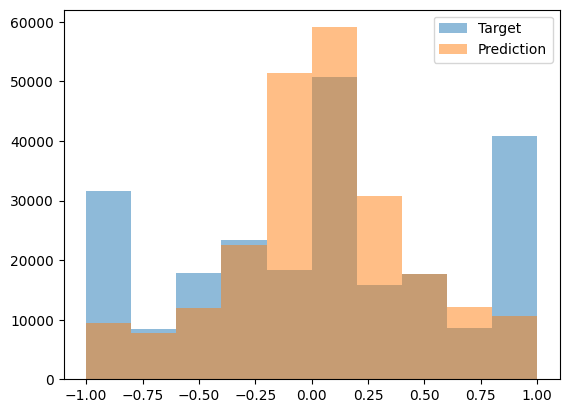

In [10]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

In [11]:
# # Predict on the test set using all trained models
# test_predictions = [
#     model.predict(df_test[numerical_cols + categorical_cols]) 
#     for model in trained_models
# ]

# # Average predictions from all models
# final_predictions = np.mean(test_predictions[0], axis=0)

# # Create a DataFrame with the predictions
# results_df = pd.DataFrame({
#     'Id': df_test['Id'],
#     'utility_agent1': final_predictions
# })

# # Save the results to a CSV file
# # results_df.to_csv('lightgbm_predictions.csv', index=Falsea)
# # print("Predictions saved to 'lightgbm_predictions.csv'")

***